In [1]:
# 🛠️ 1. Setup
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter

from torch.utils.data import Subset
import pickle

# 📦 Ensure data is downloaded and transform is applied
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# 📥 Load the EuroSAT dataset
dataset = datasets.EuroSAT(root="./data", transform=transform, download=True)

# Get class labels
class_names = dataset.classes
print("EuroSAT Classes:", class_names)


EuroSAT Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [2]:
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn

In [3]:
# 📊 2. Basic Info
print(f"Total number of images: {len(dataset)}")
print(f"Number of classes: {len(class_names)}")

Total number of images: 27000
Number of classes: 10


In [ ]:
# 📈 3. Count number of images per class
#labels = [dataset[i][1] for i in range(len(dataset))]
#label_counts = Counter(labels)

# Convert to readable format
#class_counts = {class_names[i]: label_counts[i] for i in range(len(class_names))}
#for cls, count in class_counts.items():
#    print(f"{cls:20s}: {count} images")

In [ ]:
# 📉 Optional: Visualize counts as a bar chart
#plt.figure(figsize=(10, 4))
#plt.bar(class_counts.keys(), class_counts.values())
#plt.title("Number of Images per Class in EuroSAT")
#plt.ylabel("Image Count")
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.show()

In [ ]:
# 🖼️ 4. Show Sample Images
def show_images(dataset, num_images=10):
    plt.figure(figsize=(15, 4))
    for i in range(num_images):
        img, label = dataset[i]
        img = img.permute(1, 2, 0)  # Convert [C,H,W] to [H,W,C]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(class_names[label])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images(dataset, num_images=10)


In [ ]:
# 🔍 5. Inspect Image Tensor
img_tensor, label = dataset[0]
print(f"Image tensor shape: {img_tensor.shape}")
print(f"Label index: {label} ({class_names[label]})")
print(f"Min/Max pixel value: {img_tensor.min():.2f}, {img_tensor.max():.2f}")


In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, random_split

In [5]:
# ----- 1. Bayesian Layer with Gaussian Weight Distribution -----
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_std=1.0):
        super().__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.in_features = in_features
        self.out_features = out_features

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_log_sigma = nn.Parameter(torch.Tensor(out_features, in_features).fill_(-5))
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_log_sigma = nn.Parameter(torch.Tensor(out_features).fill_(-5))

        self.prior_std = prior_std

    def forward(self, x):
        weight_sigma = torch.exp(self.weight_log_sigma)
        bias_sigma = torch.exp(self.bias_log_sigma)

        # Sample weights
        weight_eps = torch.randn_like(weight_sigma)
        bias_eps = torch.randn_like(bias_sigma)
        weight = self.weight_mu + weight_sigma * weight_eps
        bias = self.bias_mu + bias_sigma * bias_eps

        self.kl = self._kl_divergence(weight, self.weight_mu, weight_sigma) + \
                  self._kl_divergence(bias, self.bias_mu, bias_sigma)

        return F.linear(x, weight, bias)

    def _kl_divergence(self, q_sample, mu, sigma):
        # KL divergence between posterior N(mu, sigma^2) and prior N(0, prior_std^2)
        prior_sigma = self.prior_std
        return torch.sum(
            torch.log(prior_sigma / sigma) +
            (sigma**2 + mu**2) / (2 * prior_sigma**2) - 0.5
        )

# ----- 2. Bayesian Neural Network -----
class BNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.b1 = BayesianLinear(64 * 64 * 3, 128)
        self.b2 = BayesianLinear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.b1(x))
        return self.b2(x)

    def kl_loss(self):
        return self.b1.kl + self.b2.kl

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = BNN()
print(f"Using device: {device}")
model = BNN().to(device)
model.load_state_dict(torch.load(r"results_eurosat/bnn_eurosat_20250612_171219.pth", map_location=torch.device(device)))
#model.load_state_dict(torch.load(r"results_eurosat/bnn_eurosat_20250612_173201.pth", map_location=torch.device(device)))
model.eval()

Using device: cuda


BNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (b1): BayesianLinear(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (relu): ReLU()
  )
  (b2): BayesianLinear(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (relu): ReLU()
  )
)

In [ ]:
image, label = dataset[3]
input_tensor = image.unsqueeze(0).to(device)  # Add batch dimension

# Forward pass with Bayesian inference
with torch.no_grad():
    outputs = model(input_tensor)
    probs = torch.softmax(outputs, dim=1)
    pred_class = probs.argmax().item()

true_tag = "XX"

if pred_class != class_names[label]:
    true_tag = "CORRECT!!!"

print(f"True label: {class_names[label]}")
print(f"Predicted: {class_names[pred_class]} (Confidence: {probs[0][pred_class]:.2f})")

#show the image with matplotlib, with the title as the predicted class with confidence and real class
plt.imshow(image.permute(1, 2, 0))
plt.title(true_tag + f" |||BNN\nPredicted: {class_names[pred_class]} (Confidence: {probs[0][pred_class]:.2f})\nTrue label: {class_names[label]}")

In [7]:
# Define the same CNN model structure
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # -> (32, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))   # -> (64, 16, 16)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
# Load the model
model_cnn = CNN()
model_cnn.load_state_dict(torch.load("results_eurosat/cnn_model.pth", map_location="cpu"))
model_cnn.eval()  # Set to evaluation mode

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
transform_cnn = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3444, 0.3809, 0.4082], std=[0.1809, 0.1331, 0.1137])
])

# Load dataset
dataset_cnn_all = datasets.EuroSAT(root='./data', transform=transform_cnn, download=True)

with open('datasplit/split_indices.pkl', 'rb') as f:
    split = pickle.load(f)
    dataset_cnn_train = Subset(dataset, split['train'])
    dataset_cnn = Subset(dataset, split['test'])

True label: AnnualCrop
Predicted: SeaLake (Confidence: 0.53)


Text(0.5, 1.0, 'XX ||| CNN\nPredicted: SeaLake (Confidence: 0.53)\nTrue label: AnnualCrop')

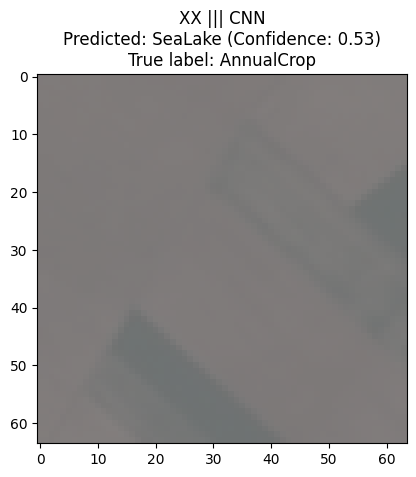

In [34]:
#image, label = dataset[25]
#input_tensor = image.unsqueeze(0).to(device)  # Add batch dimension
# Load a sample image
image, label = dataset_cnn[0]  # Pick any index
input_tensor = image.unsqueeze(0)  # Add batch dimension


# Forward pass with Bayesian inference
with torch.no_grad():
    output = model_cnn(input_tensor)  # Forward pass
    probabilities = F.softmax(output, dim=1)  # Confidence scores
    predicted_class = probabilities.argmax(dim=1).item()
    confidence = probabilities[0, predicted_class].item()

print(f"True label: {class_names[label]}")
print(f"Predicted: {class_names[predicted_class]} (Confidence: {probabilities[0][predicted_class]:.2f})")

true_tag = "XX"

if class_names[predicted_class] == class_names[label]:
    true_tag = "CORRECT!!!"

#show the image with matplotlib, with the title as the predicted class with confidence and real class
plt.imshow(image.permute(1, 2, 0).numpy() * 0.1137 + 0.4082)
plt.title(true_tag + f" ||| CNN\nPredicted: {class_names[predicted_class]} (Confidence: {probabilities[0][predicted_class]:.2f})\nTrue label: {class_names[label]}")

In [11]:
class BCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # -> (32, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))   # -> (64, 16, 16)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
# Load the model
model_bcnn = BCNN()

const_bnn_prior_parameters = {
    "prior_mu": 0.0,
    "prior_sigma": 1.0,
    "posterior_mu_init": 0.0,
    "posterior_rho_init": -3.0,
    "type": "Reparameterization",  # Flipout or Reparameterization
    "moped_enable": False,  # True to initialize mu/sigma from the pretrained dnn weights
    "moped_delta": 0.5,
    }

dnn_to_bnn(
    model_bcnn,
    const_bnn_prior_parameters
)

model_bcnn.load_state_dict(torch.load("results_eurosat/bayesian_cnn_model.pth", map_location="cpu"))
model_bcnn.eval()  # Set to evaluation mode

BCNN(
  (conv1): Conv2dReparameterization()
  (conv2): Conv2dReparameterization()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LinearReparameterization()
  (fc2): LinearReparameterization()
)

True label: AnnualCrop
Predicted: AnnualCrop (Confidence: 0.32)


Text(0.5, 1.0, 'CORRECT!!! ||| BCNN\nPredicted: AnnualCrop (Confidence: 0.32)\nTrue label: AnnualCrop')

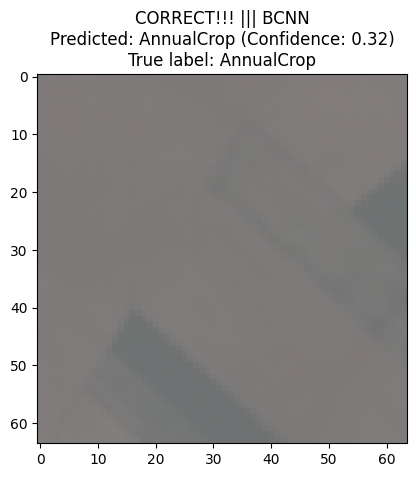

In [33]:
image, label = dataset_cnn[0]  # Pick any index
input_tensor = image.unsqueeze(0)  # Add batch dimension


# Forward pass with Bayesian inference
with torch.no_grad():
    output = model_bcnn(input_tensor)  # Forward pass
    probabilities = F.softmax(output, dim=1)  # Confidence scores
    predicted_class = probabilities.argmax(dim=1).item()
    confidence = probabilities[0, predicted_class].item()

print(f"True label: {class_names[label]}")
print(f"Predicted: {class_names[predicted_class]} (Confidence: {probabilities[0][predicted_class]:.2f})")

true_tag = "XX"

if class_names[predicted_class] == class_names[label]:
    true_tag = "CORRECT!!!"

#show the image with matplotlib, with the title as the predicted class with confidence and real class
plt.imshow(image.permute(1, 2, 0).numpy() * 0.1137 + 0.4082)
plt.title(true_tag + f" ||| BCNN\nPredicted: {class_names[predicted_class]} (Confidence: {probabilities[0][predicted_class]:.2f})\nTrue label: {class_names[label]}")

In [14]:
model_bcnn

BCNN(
  (conv1): Conv2dReparameterization()
  (conv2): Conv2dReparameterization()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LinearReparameterization()
  (fc2): LinearReparameterization()
)

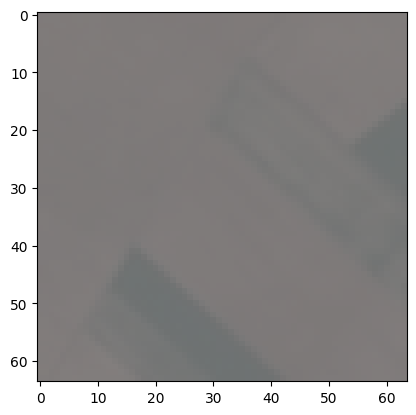

In [15]:
# make the plot as one, but show both bcnn and cnn predictions side by side
image, label = dataset_cnn[0]  # Pick any index
input_tensor = image.unsqueeze(0)  # Add batch dimension



plt.imshow(image.permute(1, 2, 0).numpy() * 0.1137 + 0.4082)

In [25]:
dataset_cnn.indices

[1152,
 13919,
 2674,
 5172,
 13668,
 16197,
 7449,
 15649,
 18035,
 14192,
 7033,
 24164,
 9896,
 5942,
 10478,
 25176,
 750,
 24431,
 3123,
 2777,
 1147,
 25886,
 2915,
 7487,
 14889,
 12431,
 26308,
 18645,
 8060,
 16757,
 20635,
 26844,
 17499,
 16716,
 4367,
 23507,
 9384,
 11721,
 14219,
 12618,
 7761,
 4226,
 2518,
 2205,
 9147,
 7887,
 3052,
 26199,
 10936,
 8815,
 3000,
 23614,
 2038,
 20921,
 8749,
 1686,
 8330,
 1705,
 2976,
 1903,
 16148,
 11719,
 23564,
 17854,
 12102,
 5527,
 26264,
 22387,
 25586,
 5867,
 3361,
 25041,
 20831,
 19331,
 14039,
 9071,
 15498,
 25004,
 18581,
 17993,
 24617,
 20389,
 26591,
 2577,
 8112,
 23502,
 7808,
 10306,
 21133,
 8391,
 26090,
 20325,
 8258,
 459,
 24337,
 16248,
 23824,
 13205,
 23493,
 8024,
 14536,
 21632,
 18294,
 21202,
 8294,
 12981,
 26412,
 20021,
 5331,
 25107,
 26228,
 16359,
 17519,
 12339,
 17866,
 25679,
 3006,
 6662,
 9991,
 8230,
 25685,
 5186,
 2300,
 1197,
 16431,
 540,
 2474,
 21811,
 5533,
 21528,
 3081,
 4724,
 260

In [27]:
len(dataset_cnn)

5400

In [28]:
len(dataset_cnn.indices)

5400

BCNN Predictions (20 samples): ['AnnualCrop', 'AnnualCrop', 'AnnualCrop', 'SeaLake', 'PermanentCrop', 'AnnualCrop', 'HerbaceousVegetation', 'AnnualCrop', 'AnnualCrop', 'SeaLake', 'AnnualCrop', 'AnnualCrop', 'AnnualCrop', 'AnnualCrop', 'AnnualCrop', 'AnnualCrop', 'SeaLake', 'AnnualCrop', 'PermanentCrop', 'HerbaceousVegetation']
tensor([0.3358])
tensor([0])


Text(0.5, 1.0, 'CNN Prediction: SeaLake (0.53)\n BCNN Prediction: AnnualCrop (0.34)\nTrue label: AnnualCrop')

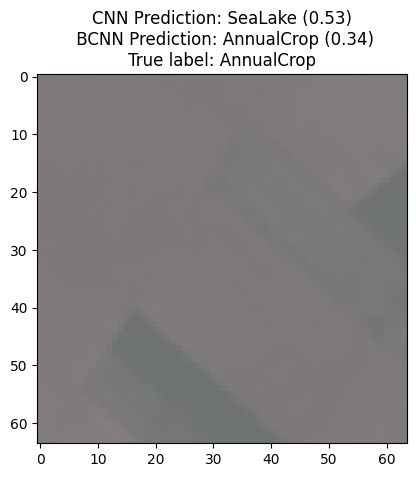

In [35]:
#image, label = dataset[25]
#input_tensor = image.unsqueeze(0).to(device)  # Add batch dimension
# Load a sample image

decision_threshold = 0.8  # Confidence threshold for known/unknown

dataset_cnn_indices = dataset_cnn.indices

image, label = dataset_cnn[0]  # Pick any index
input_tensor = image.unsqueeze(0)  # Add batch dimension


# Forward pass with Bayesian inference
with torch.no_grad():
    output = model_cnn(input_tensor)  # Forward pass
    probabilities = F.softmax(output, dim=1)  # Confidence scores
    predicted_class = probabilities.argmax(dim=1).item()
    confidence = probabilities[0, predicted_class].item()

#with torch.no_grad():
#    output_bcnn = model_bcnn(input_tensor)  # Forward pass
#    probabilities_bcnn = F.softmax(output_bcnn, dim=1)  # Confidence scores
#    predicted_class_bcnn = probabilities_bcnn.argmax(dim=1).item()
#    confidence_bcnn = probabilities_bcnn[0, predicted_class_bcnn].item()

outputs_bcnn = []
with torch.no_grad():
    for _ in range(20):  # 20 Monte Carlo samples
        output_bcnn = model_bcnn(input_tensor)
        prob_bcnn = F.softmax(output_bcnn, dim=1)
        outputs_bcnn.append(prob_bcnn)

#print the label for the highest probability for each outputs_bcnn entry
outputs_bcnn_label = [class_names[output_bcnn.argmax(dim=1)] for output_bcnn in outputs_bcnn]
print("BCNN Predictions (20 samples):", outputs_bcnn_label)

probabilities_bcnn = torch.stack(outputs_bcnn).mean(dim=0)  # shape: [1, num_classes]
predicted_class_bcnn = probabilities_bcnn.argmax(dim=1).item()

bcnn_confidences, bcnn_preds = probabilities_bcnn.max(dim=1)
print(bcnn_confidences)
print(bcnn_preds)

#print(f"True label: {class_names[label]}")
#print(f"Predicted: {class_names[predicted_class]} (Confidence: {probabilities[0][predicted_class]:.2f})")

#print(f"True label: {class_names[label]}")
#print(f"Predicted: {class_names[predicted_class]} (Confidence: {probabilities[0][predicted_class]:.2f})")

#true_tag = "XX"

#if class_names[predicted_class] == class_names[label]:
#    true_tag = "CORRECT!!!"

#show the image with matplotlib, with the title as the predicted class with confidence and real class
plt.imshow(image.permute(1, 2, 0).numpy() * 0.1137 + 0.4082)
plt.title(f"CNN Prediction: {class_names[predicted_class]} ({probabilities[0][predicted_class]:.2f})\n BCNN Prediction: {class_names[predicted_class_bcnn]} ({probabilities_bcnn[0][predicted_class_bcnn]:.2f})\nTrue label: {class_names[label]}")

In [17]:
def ensemble_predict(model, x_batch, n_samples=20):
    """Returns mean prediction probabilities over n posterior samples"""
    preds = []
    model.eval()
    with torch.no_grad():
        for _ in range(n_samples):
            output = model(x_batch)  # stochastic forward pass
            prob = F.softmax(output, dim=1)
            preds.append(prob)
    
    mean_probs = torch.stack(preds).mean(dim=0)  # shape: [batch_size, num_classes]
    return mean_probs

In [18]:
ensemble_predict(model_bcnn, input_tensor, n_samples=20)

tensor([[0.2428, 0.0048, 0.2211, 0.0579, 0.0098, 0.0143, 0.1914, 0.0178, 0.0289,
         0.2112]])

In [19]:
def predict_with_indecision(mean_probs, alpha=0.8):
    """Decide based on confidence threshold α"""
    confidences, pred_classes = mean_probs.max(dim=1)
    known_mask = confidences >= alpha
    unknown_mask = ~known_mask
    return mean_probs, pred_classes, confidences, known_mask, unknown_mask

In [20]:
predict_with_indecision(ensemble_predict(model_bcnn, input_tensor, n_samples=20), alpha=0.8)

(tensor([[0.2413, 0.0076, 0.2529, 0.0644, 0.0137, 0.0164, 0.1215, 0.0159, 0.0364,
          0.2300]]),
 tensor([2]),
 tensor([0.2529]),
 tensor([False]),
 tensor([True]))

In [21]:
def ensemble_predict_reproduce(model, x_batch, n_samples=20, seed=42):
    """Returns mean prediction probabilities over n posterior samples with reproducibility"""
    preds = []
    model.eval()
    
    # Set the seed for reproducibility
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    with torch.no_grad():
        for _ in range(n_samples):
            output = model(x_batch)  # stochastic forward pass
            prob = F.softmax(output, dim=1)
            preds.append(prob)
    
    mean_probs = torch.stack(preds).mean(dim=0)  # shape: [batch_size, num_classes]
    return mean_probs

tensor([0.4866])
tensor([9])


Text(0.5, 1.0, 'CNN Prediction: SeaLake (1.00)\n BCNN Prediction: SeaLake (0.49)\nTrue label: Pasture')

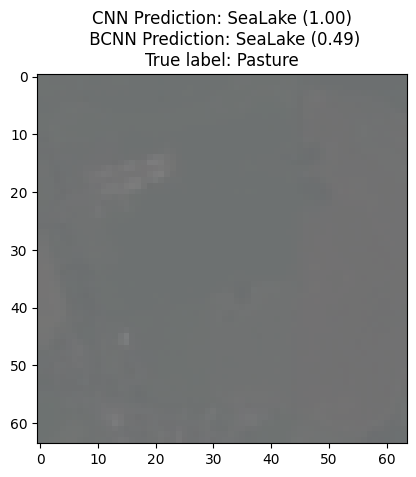

In [23]:
image, label = dataset_cnn[7]  # Pick any index
input_tensor = image.unsqueeze(0)  # Add batch dimension
reproduce_seed = 42  # Set a seed for reproducibility

### NORMAL CNN PREDICTION

with torch.no_grad():
    output = model_cnn(input_tensor)  # Forward pass
    probabilities = F.softmax(output, dim=1)  # Confidence scores
    predicted_class = probabilities.argmax(dim=1).item()
    confidence = probabilities[0, predicted_class].item()

### BAYESIAN CNN

decision_threshold = 0.8  # Confidence threshold for known/unknown

bcnn_mean_probs, bcnn_classes, bcnn_confidences, bcnnKnownMask, bcnnUnknownMask = predict_with_indecision(ensemble_predict_reproduce(model_bcnn, input_tensor, n_samples=20, seed=reproduce_seed), alpha=0.8)

bcnn_confidences, bcnn_preds = bcnn_mean_probs.max(dim=1)
print(bcnn_confidences)
print(bcnn_preds)

#show the image with matplotlib, with the title as the predicted class with confidence and real class
plt.imshow(image.permute(1, 2, 0).numpy() * 0.1137 + 0.4082)
plt.title(f"CNN Prediction: {class_names[predicted_class]} ({probabilities[0][predicted_class]:.2f})\n BCNN Prediction: {class_names[bcnn_preds]} ({float(bcnn_confidences):.2f})\nTrue label: {class_names[label]}")

In [22]:
len(dataset_cnn)

5400

In [34]:
# create a loop for all images in dataset_cnn and record the prediction in a dataframe
import pandas as pd
from tqdm import tqdm

predictions_df = pd.DataFrame(columns=["Image Index", "CNN Predicted", "CNN Confidence", "BCNN Predicted", "BCNN Confidence", "True Label", "Reproduce Seed"])

total_len = len(dataset_cnn)
start_idx = int(total_len * 0)  # index where last 5% starts

for i in tqdm(range(start_idx, total_len)):

#for i in tqdm(range(len(dataset_cnn))):
#for i in range(5):
    image, label = dataset_cnn[i]  # Pick any index
    input_tensor = image.unsqueeze(0)  # Add batch dimension

    # Normal CNN prediction
    with torch.no_grad():
        output = model_cnn(input_tensor)  # Forward pass
        probabilities = F.softmax(output, dim=1)  # Confidence scores
        predicted_class = probabilities.argmax(dim=1).item()
        confidence = probabilities[0, predicted_class].item()

    # Bayesian CNN prediction
    bcnn_mean_probs, bcnn_classes, bcnn_confidences, bcnnKnownMask, bcnnUnknownMask = predict_with_indecision(
        ensemble_predict_reproduce(model_bcnn, input_tensor, n_samples=20, seed=reproduce_seed), alpha=0.8)

    bcnn_confidences, bcnn_preds = bcnn_mean_probs.max(dim=1)
    
    #print(f"Image {i}: CNN Predicted: {class_names[predicted_class]} ({probabilities[0][predicted_class]:.2f}), "
    #      f"BCNN Predicted: {class_names[bcnn_preds]} ({float(bcnn_confidences):.2f}), True label: {class_names[label]}")
    
    # Append to DataFrame
    new_row = pd.DataFrame([{
        "Image Index": i,
        "CNN Predicted": class_names[predicted_class],
        "CNN Confidence": probabilities[0][predicted_class].item(),
        "BCNN Predicted": class_names[bcnn_preds],
        "BCNN Confidence": float(bcnn_confidences),
        "BCNN Unknown": bcnnUnknownMask.item(),
        "True Label": class_names[label],
        "Reproduce Seed": reproduce_seed
    }])

    predictions_df = pd.concat([predictions_df, new_row], ignore_index=True)

# Save predictions to CSV with timestamp
# add timestamp to filename

import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
predictions_df.to_csv("predictions_eurosat_"+timestamp+".csv", index=False)

  0%|          | 0/5400 [00:00<?, ?it/s]C:\Users\Revalda Putawara\AppData\Local\Temp\ipykernel_21484\332117185.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predictions_df = pd.concat([predictions_df, new_row], ignore_index=True)
100%|██████████| 5400/5400 [30:15<00:00,  2.97it/s]


In [24]:
len(dataset_cnn)

5400

In [25]:
import pandas as pd

In [ ]:
#predictions_df = pd.read_csv("predictions_eurosat_20250617_205043.csv")

In [35]:
# compute the accuracy of the predictions
cnn_correct = (predictions_df["CNN Predicted"] == predictions_df["True Label"]).sum()
bcnn_correct = (predictions_df["BCNN Predicted"] == predictions_df["True Label"]).sum()
# compute accuracy for BCNN known classes
predictions_df["BCNN Known"] = predictions_df["BCNN Confidence"] >= 0.8
bcnn_known_correct = (predictions_df[predictions_df["BCNN Known"]]["BCNN Predicted"] == predictions_df[predictions_df["BCNN Known"]]["True Label"]).sum()
bcnn_known_total = predictions_df["BCNN Known"].sum()

print(f"CNN Accuracy: {cnn_correct / len(predictions_df) * 100:.2f}%")
print(f"BCNN Accuracy: {bcnn_correct / len(predictions_df) * 100:.2f}%")
print(f"BCNN Known Classes Accuracy: {bcnn_known_correct / bcnn_known_total * 100:.2f}%")

CNN Accuracy: 14.69%
BCNN Accuracy: 18.70%
BCNN Known Classes Accuracy: 100.00%


In [36]:
# create a column, if the confidence is above 0.8, then it is a known class, otherwise unknown
predictions_df["BCNN Known"] = predictions_df["BCNN Confidence"] >= 0.8

In [37]:
predictions_df.head()

,Image Index,CNN Predicted,CNN Confidence,BCNN Predicted,BCNN Confidence,True Label,Reproduce Seed,BCNN Unknown,BCNN Known
0,0,SeaLake,0.526836,AnnualCrop,0.354349,AnnualCrop,42,True,False
1,1,HerbaceousVegetation,0.907341,AnnualCrop,0.376798,Industrial,42,True,False
2,2,SeaLake,0.941721,SeaLake,0.363608,AnnualCrop,42,True,False
3,3,SeaLake,0.999984,SeaLake,0.663620,Forest,42,True,False
4,4,AnnualCrop,0.787906,AnnualCrop,0.290685,Industrial,42,True,False


In [38]:
bcnn_known_total

np.int64(32)